<a href="https://colab.research.google.com/github/RaquelGrosman/BigD/blob/master/1.0_Week2_BEG_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

obs_collection project                        obs_id                       
-------------- ------- ----------------------------------------------------
          TESS    TESS      tess2018206045859-s0001-0000000388104525-0120-s
          TESS    TESS tess2018206190142-s0001-s0002-0000000388104525-00111
          TESS    TESS tess2018206190142-s0001-s0003-0000000388104525-00129
          TESS    TESS tess2018206190142-s0001-s0006-0000000388104525-00196
          TESS    TESS tess2018206190142-s0001-s0009-0000000388104525-00205
          TESS    TESS tess2018206190142-s0001-s0013-0000000388104525-00226
          TESS    TESS      tess2018234235059-s0002-0000000388104525-0121-s
          TESS    TESS      tess2018263035959-s0003-0000000388104525-0123-s
          TESS    TESS      tess2018292075959-s0004-0000000388104525-0124-s
          TESS    TESS      tess2019006130736-s0007-0000000388104525-0131-s
          TESS    TESS      tess2019112060037-s0011-0000000388104525-0143-s
INFO: Found 

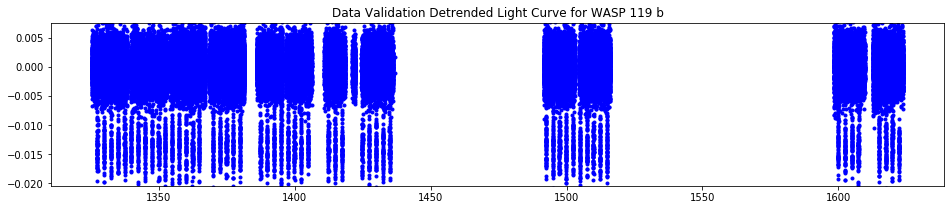

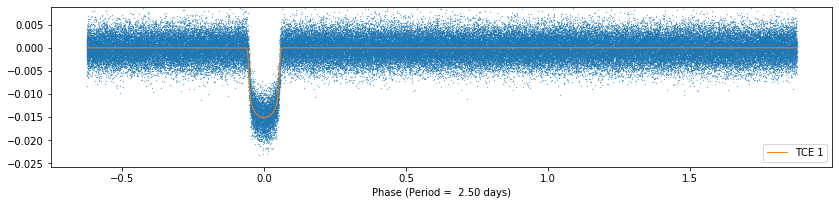

In [5]:
!pip install astroquery
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy import table
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as p
from IPython.display import display, HTML
from copy import deepcopy

#this is beg dv
star_name = "WASP 119 b" #Valentine's Planet <3

observations = Observations.query_object(star_name,radius = "0 deg")
obs_wanted = (observations['dataproduct_type'] == 'timeseries') & (observations['obs_collection'] == 'TESS')
print( observations[obs_wanted]['obs_collection', 'project','obs_id'] )

data_products = Observations.get_product_list(observations[obs_wanted])
products_wanted = Observations.filter_products(data_products, 
                                    productSubGroupDescription=["DVT","DVM","DVS","DVR"])

#print(products_wanted["productFilename"])
manifest = Observations.download_products(products_wanted)

#print( manifest['Local Path'] )

def parse_manifest(manifest):
    """
    Parse manifest and add back columns that are useful for TESS DV exploration.
    """
    results = deepcopy(manifest)
    filenames = []
    sector_range = []
    exts = []
    for i,f in enumerate(manifest['Local Path']):
        file_parts = np.array(np.unique(f.split(sep = '-')))
        sectors = list( map ( lambda x: x[0:2] == 's0', file_parts))
        s1 = file_parts[sectors][0]
        try:
            s2 = file_parts[sectors][1]
        except:
            s2 = s1
        sector_range.append("%s-%s" % (s1,s2))
        path_parts = np.array(f.split(sep = '/'))
        filenames.append(path_parts[-1])
        exts.append(path_parts[-1][-8:])

    results.add_column(table.Column(name = "filename", data = filenames))
    results.add_column(table.Column(name = "sectors", data = sector_range))
    results.add_column(table.Column(name = "fileType", data = exts))
    results.add_column(table.Column(name = "index", data = np.arange(0,len(manifest))))
    
    return results

#Run parser and print
results = parse_manifest(manifest)
#print(results['index','sectors','fileType'])

#print(results['index', 'sectors', 'fileType'][results['sectors'] == "s0001-s0013"])

# Locate the file that has the data
want = (results['sectors'] == "s0001-s0013") & (results['fileType'] == "dvt.fits")
dvt_filename = manifest[want]['Local Path'][0]

# Print out the file info
fits.info(dvt_filename)

# Plot the detrended photometric time series in the first binary table. 
data = fits.getdata(dvt_filename, 1)
time = data['TIME']
relflux = data['LC_DETREND']

plt.figure(figsize = (16,3))
plt.plot (time, relflux, 'b.')
plt.ylim(1.2* np.nanpercentile(relflux, .5) , 1.2 * np.nanpercentile(relflux, 99.5))
plt.title('Data Validation Detrended Light Curve for %s' % (star_name))

def plot_folded(phase, data, model, ext, period):
    isort = phase.argsort()   
    plt.plot(phase[isort], data[isort], '.', ms = .5)
    plt.plot(phase[isort], model[isort], '-', lw = 1, label = "TCE %i" % ext)
    plt.xlabel('Phase (Period = %5.2f days)' % period)
    plt.ylim(1.5 * np.nanpercentile(data, .5) , 1.4 * np.nanpercentile(data,99.5))
    plt.legend(loc = "lower right")
plt.figure(figsize = (14,10))
nTCEs = fits.getheader(dvt_filename)['NEXTEND'] - 2

for ext in range(1, nTCEs + 1):
    data = fits.getdata(dvt_filename, ext)
    head = fits.getheader(dvt_filename, ext)
    period = head['TPERIOD']
    phase = data['PHASE']
    flux = data['LC_INIT']
    model = data['MODEL_INIT']
    plt.subplot(3, 1, ext)
    plot_folded(phase, flux, model, ext, period)






In [10]:
### 
# #importing 
# import numpy as np
# import requests
# import matplotlib.pyplot as plt
# import pandas as p
# from IPython.display import display, HTML

# %matplotlib inline

# planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
# dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
# header={}

# planet_name = "WASP 119 b"

# url = planeturl + "/identifiers/"

# myparams = {"name":planet_name}

# r = requests.get(url = url, params = myparams, headers = header)
# print(r.headers.get('content-type'))

# planet_names = r.json()
# ticid = planet_names['tessID']
# tce = planet_names['tessTCE']
# planet_names

# url = planeturl + planet_name + "/properties/"

# r = requests.get(url = url, headers = header)

# planet_prop = r.json()

# print("Catalog 1: " + planet_prop[0]['catalog_name'])
# print("Catalog 2: " + planet_prop[0]['catalog_name']) 
# planet_prop[0].keys()

# print("WASP 119 b Properties")
# print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
# print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
# print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

# url = dvurl + str(ticid) + '/tces/'
# myparams = {"tce" : tce}

# r = requests.get(url = url, params = myparams, headers = header)
# sectorInfo = r.json()

# sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
# sectors

# url = dvurl + str(ticid) + '/info/'
# myparams = {"tce" : tce,
#             "sector" : sectors[0]}

# r = requests.get(url = url, params = myparams, headers = header)
# tceInfo = r.json()
# tceInfo.keys()
# tceInfo['DV Data Header'].keys()

# print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
# print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

# # Get The data
# url = dvurl + str(ticid) + '/table/'
# myparams = {"tce" : tce,
#             "sector" : sectors[0]}

# r = requests.get(url = url, params = myparams, headers = header)
# tce_data = r.json()
# data = p.DataFrame.from_dict(tce_data['data'])
# data.columns

# detrend = data['LC_DETREND']
# model = data['MODEL_INIT']
# time = data['TIME']

# plt.figure(figsize=(14,4))
# plt.plot(time,detrend,'.',lw=0.4)
# plt.plot(time,model,'r-',lw=0.6)
# plt.xlabel('TIME (BTJD)')
# plt.ylabel('Relative Flux')

# url = dvurl + str(ticid) + '/phaseplot/'
# myparams = {"tce" : tce,
#             "sector" : sectors[0]}

# r = requests.get(url = url, params = myparams, headers = header)
# display(HTML(str(r.content.decode('utf-8'))))

application/json; charset=UTF-8


IndexError: ignored